In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import base64
import codecs
from functools import partial
from math import ceil, floor
from importlib import reload
import pickle

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.misc import imresize
import tensorflow as tf
print(tf.__version__)

from include import classifiers
from include import graph_manager
from include import viz_utils
from include import dataset_utils
from include import preprocess_utils

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

1.12.0


In [9]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def floats_feature(value):
    return tf.train.Feature(int64_list=tf.train.FloatList(value=value))

# Input Pipeline

This notebook contains minimal code to generate `TFRecords` from the raw MNIST, PACS and ILSVRC2012 datasets and generate `train/val/test` split accordingly. 

These `TFRecords` are then used in `settings.py` to generate shifted and subsampled datasets.


### Table of Contents

  * [MNIST](#mnist)
  * [MNIST-M](#mnistm)
  * [SVHN](#svhn)
  * [PACS](#pacs)
  * [ILSVRC](#ilsvrc)

## MNIST
---
<a name="mnist"></a>

1. Parse data and store in TFRecords

In [32]:
data_dir = '/home/aroyer/Data/MNIST/'     # source director
target_path = 'Data/tf_mnist_%s'    
    
### Parse the dataset
def read_integer(bytel):
    return int('0x' + ''.join('{:02x}'.format(x) for x in bytel), 0)

data = []
for name, key in [('train', 'train'), ('test', 't10k')]:
    # read images
    images = os.path.join(data_dir, '%s-images.idx3-ubyte' % key)    
    with codecs.open(images, 'r', 'latin-1') as f:
        block = list(bytearray(f.read(), 'latin-1'))
        assert(not(block[0] | block[1]))
    num_items = read_integer(block[4:8])
    num_rows = read_integer(block[8:12])
    num_columns = read_integer(block[12:16])
    images = np.reshape(np.array(block[16:]), (num_items, num_rows, num_columns))
    images = images.astype(np.uint8)
    # read labels
    labels = os.path.join(data_dir, '%s-labels.idx1-ubyte' % key)
    with codecs.open(labels, 'r', 'latin-1') as f:
        labels = list(bytearray(f.read(), 'latin-1'))[8:]
    # split
    # first 5000 train images will be validation
    # remaining 55000 are in train
    # original 10000 test images
    if name == 'train':
        data.append(('train', images[5000:], labels[5000:]))
        data.append(('val', images[:5000], labels[:5000]))
    else:
        data.append(('test', images, labels))

### Write in TFRecords
for name, images, labels in data:    
    writer_path = target_path % name   # TFrecords output path
    writer = tf.python_io.TFRecordWriter(writer_path)
    for index in range(len(labels)):
        print('\rLoad %s: %d / %d' % (name, index + 1, len(labels)), end='')
        img = images[index]
        class_id = int(labels[index])
        example = tf.train.Example(features=tf.train.Features(feature={
            'class': int64_feature([class_id]),
            'image': bytes_feature([img.tostring()])}))                
        writer.write(example.SerializeToString())
    writer.close()
    print('\nWrote %s in file %s' % (name, writer_path))
    print()

Load train: 55000 / 55000
Wrote train in file Data/tf_mnist_train

Load val: 5000 / 5000
Wrote val in file Data/tf_mnist_val

Load test: 10000 / 10000
Wrote test in file Data/tf_mnist_test



2. Vizualise

   class: (?,)
   image: (?, 28, 28, 1)
   5000 samples in dataset
   0 (479), 1 (563), 2 (488), 3 (493), 4 (535), 5 (434), 6 (501), 7 (550), 8 (462), 9 (495)


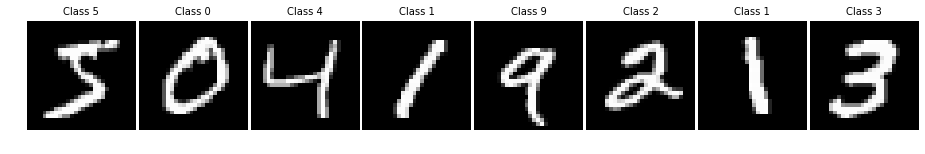

In [4]:
mode = 'val'
verbose = True
viz_utils.display_dataset(partial(dataset_utils.get_mnist_dataset, **{
        'batch_size': 8, '%s_tfrecords' % mode: target_path % mode}), 
                          mode=mode, verbose=True)

4. Pretrain a base model and save in `Data/pretrained_models/pretrained_mnist`

In [7]:
# Initialize configuration
output_dir = 'Data/pretrained_models'
save_log_dir = os.path.join(output_dir, 'pretrained_mnist/')
tfrecords_path = 'Data/mnist/tf_mnist_%s'

config = {}
config['batch_size'] = 50
for key in ['train', 'val', 'test']:
    config['%s_tfrecords' % key] = tfrecords_path % key

In [ ]:
# Train
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
pretrain_config = config.copy()
pretrain_config['num_epochs'] = 25
pretrain_config['learning_rate'] = 1e-4
pretrain_config['shuffle_buffer'] = 10000
pretrain_config['num_train_devices'] = 1
pretrain_config['save_checkpoint_secs'] = 3600
for key in ['train', 'val', 'test']:
    config['%s_tfrecords' % key] = tfrecords_path % key
    
classifier = classifiers.MNISTClassifier(dataset_utils.get_mnist_dataset, config=pretrain_config)
classifier.train_and_eval(save_checkpoint_secs=pretrain_config['save_checkpoint_secs'], 
                          save_log_dir=save_log_dir, 
                          display_step=100, 
                          verbose=True)

5. Evaluate the pretrained model

In [11]:
%%time
# Evaluate
classifier = classifiers.MNISTClassifier(dataset_utils.get_mnist_dataset, config=config)
_ = classifier.test(save_log_dir, mode='val', verbose=False)
classifier.reset_graph()
_ = classifier.test(save_log_dir, mode='test', verbose=False)
print(classifier.info)

Config
------
*batch_size* = 50
*test_tfrecords* = Data/mnist/tf_mnist_test
*train_tfrecords* = Data/mnist/tf_mnist_train
*val_tfrecords* = Data/mnist/tf_mnist_val
*dataset_fn* = functools.partial(<function _get_basic_dataset at 0x7f8080eb6d08>, parsing_fn=<function mnist_parsing_fn at 0x7f8080eb6488>)
*preprocess_fn* = functools.partial(<function pix2pix_preprocess at 0x7f815a124b70>, num_outputs=1)
*transition_fn* = <function mnist_transition at 0x7f8080eb90d0>
*feed_forward_fn* = <function mnist_net at 0x7f8080eb91e0>

val evaluation log
--------
   Loading mnist_net checkpoint from Data/pretrained_models/pretrained_mnist/model.ckpt-6250
   Restoring variables
      > mnist_net/layer_1/conv_1/weights:0
      > mnist_net/layer_1/conv_1/biases:0
      > mnist_net/layer_2/conv_2/weights:0
      > mnist_net/layer_2/conv_2/biases:0
      > mnist_net/layer_3/fc_1/weights:0
      > mnist_net/layer_3/fc_1/biases:0
      > mnist_net/layer_4/fc_2/weights:0
      > mnist_net/layer_4/fc_2/biase

# MNIST-M
---

<a name="mnistm"></a>
1. Create the MNIST-M dataset, using the BSR dataset for background patches

In [45]:
import tarfile
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

# Get BSR dataset to generate backgrounds
BST_PATH = '/home/aroyer/Data/BSR_bsds500.tgz'
rand = np.random.RandomState(42)
f = tarfile.open(BST_PATH)
train_files = []
for name in f.getnames():
    if name.startswith('BSR/BSDS500/data/images/train/'):
        train_files.append(name)
print('Loading BSR training images')
background_data = []
for name in train_files:
    try:
        fp = f.extractfile(name)
        bg_img = mpimg.imread(fp)
        background_data.append(bg_img)
    except:
        continue

def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)    
    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)

def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)

def create_mnistm(X):
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):
        if i % 1000 == 0:
            print('\rProcessing example %d' % i, end='')
        bg_img = rand.choice(background_data)
        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d
    print()
    return X_

# `data`: See previous section (MNIST) to generate
# We build MNIST-M based on the split given in `data`
print('Building train set...')
train_images = create_mnistm(mnist.train.images)
data[0] = ('train', train_images, data[0][-1])
print('Building test set...')
test_images = create_mnistm(mnist.test.images)
data[2] = ('test', test_images, data[2][-1])
print('Building validation set...')
valid_images = create_mnistm(mnist.validation.images)
data[1] = ('val', valid_images, data[1][-1])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Loading BSR training images
Building train set...
Processing example 54000
Building test set...
Processing example 9000
Building validation set...
Processing example 4000


2. Write in TFRecords

In [46]:
target_path = 'Data/tf_mnist-m_%s'

for name, images, labels in data:    
    writer_path = target_path % name
    writer = tf.python_io.TFRecordWriter(writer_path)
    for index in range(len(labels)):
        print('\rLoad %s: %d / %d' % (name, index + 1, len(labels)), end='')
        img = images[index].astype(np.uint8)
        class_id = int(labels[index])
        example = tf.train.Example(features=tf.train.Features(feature={
            'class': int64_feature([class_id]),
            'image': bytes_feature([img.tostring()])}))                
        writer.write(example.SerializeToString())
    writer.close()
    print('\nWrote %s in file %s' % (name, writer_path))
    print()

Load train: 55000 / 55000
Wrote train in file Data/tf_mnist-m_train

Load val: 5000 / 5000
Wrote val in file Data/tf_mnist-m_val

Load test: 10000 / 10000
Wrote test in file Data/tf_mnist-m_test



3. Visualize

   class: (?,)
   image: (?, 28, 28, 3)
   5000 samples in dataset
   0 (479), 1 (563), 2 (488), 3 (493), 4 (535), 5 (434), 6 (501), 7 (550), 8 (462), 9 (495)


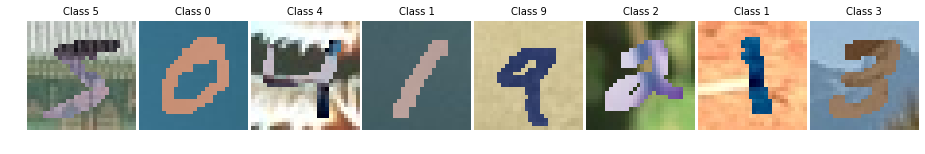

In [12]:
mode = 'val'
verbose = True
viz_utils.display_dataset(partial(dataset_utils.get_mnistm_dataset, **{
    'batch_size': 8, '%s_tfrecords' % mode: target_path % mode}), 
                          mode=mode, verbose=True)

# SVHN
---
<a name="svhn"></a>

In [6]:
import scipy.io
data_dir = '/home/aroyer/Data/SVHN/'
target_path = 'Data/tf_svhn_%s'

data = []
for name, key in [('train', 'train'), ('test', 'test')]:
    mat = os.path.join(data_dir, '%s_32x32.mat' % key)
    mat = scipy.io.loadmat(mat)
    images, labels = mat['X'], mat['y']
    if name == 'train':
        data.append(('train', images[:, :, :, 10000:], labels[10000:]))
        data.append(('val', images[:, :, :, :10000], labels[:10000]))
    else:
        data.append(('test', images, labels))

for name, images, labels in data:
    num_items = labels.shape[0]
    # Write
    writer_path = target_path % name
    writer = tf.python_io.TFRecordWriter(writer_path)
    for index in range(num_items):
        print('\rLoad %s: %d / %d' % (name, index + 1, num_items), end='')
        img = images[:, :, :, index]
        img = img.astype(np.uint8)
        class_id = int(labels[index, 0])
        class_id = 0 if class_id == 10 else class_id
        example = tf.train.Example(features=tf.train.Features(feature={
            'class': int64_feature([class_id]),
            'image': bytes_feature([img.tostring()])}))
        writer.write(example.SerializeToString())
    writer.close()
    print('\nWrote %s in file %s' % (name, writer_path))
    print()

Load train: 63257 / 63257
Wrote train in file tf_svhn_train

Load val: 10000 / 10000
Wrote val in file tf_svhn_val

Load test: 26032 / 26032
Wrote test in file tf_svhn_test



   class: (?,)
   image: (?, 32, 32, 3)
   10000 samples in dataset
   0 (684), 1 (1926), 2 (1422), 3 (1138), 4 (1067), 5 (955), 6 (772), 7 (728), 8 (673), 9 (635)


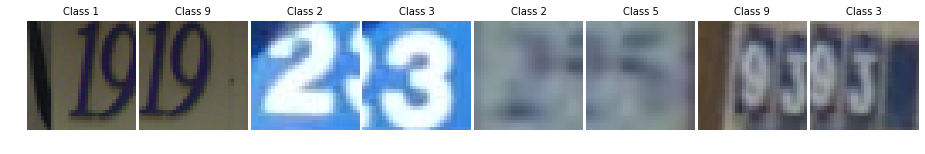

In [13]:
mode = 'val'
verbose = True
viz_utils.display_dataset(partial(dataset_utils.get_svhn_dataset, **{
    'batch_size': 8, '%s_tfrecords' % mode: target_path % mode}), 
                          mode=mode, verbose=True)

# PACS
---

<a name="pacs"></a>

See [TFDatasets](https://github.com/ameroyer/TFDatasets) to generate the `train/val/test` split TFRecords from the original PACS dataset.

1. Here we visualize the validation split for each art style

   class: (?,)
   image: (?, 224, 224, 3)
   164 samples in dataset
   0 (18), 1 (20), 2 (18), 3 (18), 4 (19), 5 (28), 6 (43)


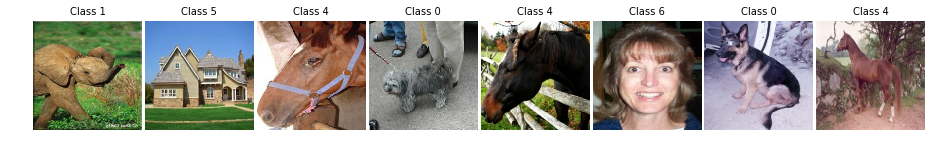

In [15]:
viz_utils.display_dataset(partial(dataset_utils.get_pacs_dataset,
                                  batch_size=8,
                                  image_dir=os.path.expanduser('~/Datasets/PACS/'),
                                  image_size=224,                                  
                                  shuffle_buffer=300,
                                  shuffle_test=True,
                                  val_tfrecords='Data/pacs/tf_pacs_photo_val'),
                          mode='val', verbose=True)

   class: (?,)
   image: (?, 224, 224, 3)
   201 samples in dataset
   0 (37), 1 (25), 2 (28), 3 (18), 4 (20), 5 (29), 6 (44)


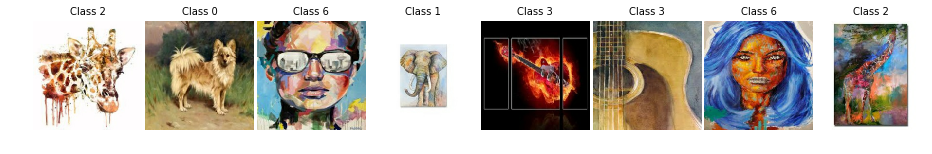

In [17]:
viz_utils.display_dataset(partial(dataset_utils.get_pacs_dataset,
                                  batch_size=8,
                                  image_dir=os.path.expanduser('~/Datasets/PACS/'),
                                  image_size=224,                                  
                                  shuffle_buffer=300,
                                  shuffle_test=True,
                                  val_tfrecords='Data/pacs/tf_pacs_art_painting_val'),
                          mode='val', verbose=True)

   class: (?,)
   image: (?, 224, 224, 3)
   230 samples in dataset
   0 (38), 1 (45), 2 (34), 3 (13), 4 (32), 5 (28), 6 (40)


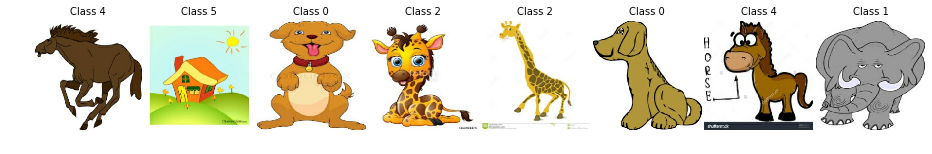

In [18]:
viz_utils.display_dataset(partial(dataset_utils.get_pacs_dataset,
                                  batch_size=8,
                                  image_dir=os.path.expanduser('~/Datasets/PACS/'),
                                  image_size=224,                                  
                                  shuffle_buffer=300,
                                  shuffle_test=True,
                                  val_tfrecords='Data/pacs/tf_pacs_cartoon_val'),
                          mode='val', verbose=True)

   class: (?,)
   image: (?, 224, 224, 3)
   201 samples in dataset
   0 (37), 1 (25), 2 (28), 3 (18), 4 (20), 5 (29), 6 (44)


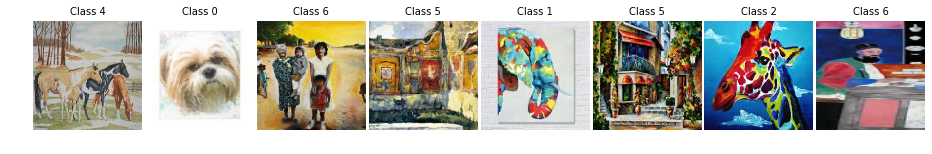

In [20]:
viz_utils.display_dataset(partial(dataset_utils.get_pacs_dataset,
                                  batch_size=8,
                                  image_dir=os.path.expanduser('~/Datasets/PACS/'),
                                  image_size=224,  
                                  shuffle_buffer=300,
                                  shuffle_test=True,
                                  val_tfrecords='Data/pacs/tf_pacs_art_painting_val'),
                          mode='val', verbose=True)

2. Fine-tune Inception v2 on PACS photo to be used as a base pretrained model

In [101]:
# Initialize configuration
output_dir = 'Data/pretrained_models/'
save_log_dir = os.path.join(output_dir, 'pretrained_pacs_photo/')
tfrecords_path = 'Data/pacs/tf_pacs_photo_%s'

config = {}
config['batch_size'] = 32
config['image_size'] = 224
config['image_dir'] = os.path.expanduser('~/Datasets/PACS/')
for key in ['train', 'val', 'test']:
    config['%s_tfrecords' % key] = tfrecords_path % key

In [ ]:
# Train
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
pretrain_config = config.copy()
pretrain_config['learning_rate'] = 1e-4
pretrain_config['shuffle_buffer'] = 10000
pretrain_config['num_train_devices'] = 4
pretrain_config['batch_size'] = 8 * pretrain_config['num_train_devices']
pretrain_config['num_epochs'] = 100
pretrain_config['save_checkpoint_secs'] = 3600

classifier = classifiers.PACSClassifier(dataset_utils.get_pacs_dataset, config=pretrain_config)
classifier.train_and_eval(
    save_checkpoint_secs=pretrain_config['save_checkpoint_secs'], 
    save_log_dir=save_log_dir,
    restore_model_dir='Data/ilsvrc2012/pretrained/pretrained_ilsvrc2012/', # start from ImageNet pretrained
    exclude_restore_model_scopes=['imagenet_net/InceptionV2/logits'],      # do not restore logit layers
    verbose=True)

3. Test the pretrained classifier

In [24]:
%%time
# Evaluate
classifier = classifiers.PACSClassifier(dataset_utils.get_pacs_dataset, config=config)

top1_accuracy_, top5_accuracy_ = classifier.test(
    save_log_dir, mode='val', verbose=True)
print('val accuracy = %.5f, top5 = %.5f' % (top1_accuracy_, top5_accuracy_))

classifier.reset_graph()
top1_accuracy_, top5_accuracy_ = classifier.test(
    save_log_dir, mode='test', verbose=True)
print('test accuracy = %.5f, top5 = %.5f' % (top1_accuracy_, top5_accuracy_))

   Loading imagenet_net checkpoint from Data/pretrained_models/pretrained_pacs_photo/model.ckpt-2000
   (eval) step 0          
val accuracy = 0.96341, top5 = 1.00000
   Loading imagenet_net checkpoint from Data/pretrained_models/pretrained_pacs_photo/model.ckpt-2000
   (eval) step 0          
test accuracy = 0.96460, top5 = 1.00000
CPU times: user 11.3 s, sys: 754 ms, total: 12 s
Wall time: 15.3 s


4. test PACS from ImageNet logits

In [102]:
%%time
# Evaluate
save_log_dir = 'Data/pretrained_models/pretrained_ilsvrc2012/'

classifier = classifiers.PACSFromImagenetClassifier(dataset_utils.get_pacs_dataset, config=config)

top1_accuracy_, top5_accuracy_ = classifier.test(
    save_log_dir, mode='val', verbose=True)
print('val accuracy = %.5f, top5 = %.5f' % (top1_accuracy_, top5_accuracy_))

classifier.reset_graph()
top1_accuracy_, top5_accuracy_ = classifier.test(
    save_log_dir, mode='test', verbose=True)
print('test accuracy = %.5f, top5 = %.5f' % (top1_accuracy_, top5_accuracy_))

   Loading imagenet_net checkpoint from Data/pretrained_models/pretrained_ilsvrc2012/model
   (eval) step 0          
val accuracy = 0.87805, top5 = 0.98780
   Loading imagenet_net checkpoint from Data/pretrained_models/pretrained_ilsvrc2012/model
   (eval) step 0          
test accuracy = 0.88496, top5 = 0.99410
CPU times: user 13.1 s, sys: 516 ms, total: 13.6 s
Wall time: 13.3 s


# ILSVRC-2012

<a name="ilsvrc"></a>

1. Write TFRecords of the base ILSVRC2012-val split

In [ ]:
image_dir = './val'
image_files = sorted(os.listdir(image_dir))
writer = tf.python_io.TFRecordWriter('Data/ilsvrc2012/tf_ilsvrc2012_base')

for i, (img, ann) in enumerate(zip(image_files, annot)):
    print('\r%d/%d' % (i + 1, len(image_files)), end='')
    feature = {}
    img_path = os.path.join(image_dir, img)
    feature['image'] = bytes_feature([base64.b64encode(img_path.encode('utf-8'))])
    feature['class'] = int64_feature([ann[0]])
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
writer.close()

2. We split the initial ILSVRC2012 val dataset into 25k images for training domain shifts, 5k images for validations and finally 20k images for testing

In [3]:
preprocess_utils.split_tf_records('Data/ilsvrc2012/tf_ilsvrc2012_base', 
                                 'Data/ilsvrc2012/tf_ilsvrc2012_0-25_train', 
                                 take=25000, shuffle=True, seed=42, num_elements=50000)
preprocess_utils.split_tf_records('Data/ilsvrc2012/tf_ilsvrc2012_base', 
                                 'Data/ilsvrc2012/tf_ilsvrc2012_25-30_val', 
                                 skip=25000, take=5000, shuffle=True, seed=42, num_elements=50000)
preprocess_utils.split_tf_records('Data/ilsvrc2012/tf_ilsvrc2012_base', 
                                 'Data/ilsvrc2012/tf_ilsvrc2012_30-50_test', 
                                 skip=30000, shuffle=True, seed=42, num_elements=50000)

3. Visualize images from the generated val split and class repartition

   class: (?,)
   class_name: (?,)
   image: (?, 224, 224, 3)
   5000 samples in dataset
   0 (2), 1 (6), 2 (2), 3 (3), 4 (3), 5 (7), 6 (2), 7 (4), 8 (10), 9 (3), 10 (5), 11 (8), 12 (1), 13 (4), 14 (4), 15 (1), 16 (6), 17 (10), 18 (5), 19 (10), 20 (6), 21 (6), 22 (3), 23 (5), 24 (1), 25 (8), 26 (3), 27 (4), 28 (3), 29 (4), 30 (5), 31 (6), 32 (4), 33 (1), 34 (5), 35 (5), 36 (2), 37 (6), 38 (2), 39 (9), 40 (8), 41 (5), 42 (5), 43 (3), 44 (6), 45 (6), 46 (11), 47 (6), 48 (10), 49 (9), 50 (4), 51 (6), 52 (5), 53 (8), 54 (8), 55 (2), 56 (9), 57 (4), 58 (6), 59 (4), 60 (7), 61 (4), 62 (4), 63 (5), 64 (6), 65 (2), 66 (7), 67 (10), 68 (5), 69 (5), 70 (11), 71 (4), 72 (7), 73 (7), 74 (6), 75 (2), 76 (6), 77 (4), 78 (8), 79 (10), 80 (5), 81 (9), 82 (4), 83 (5), 84 (4), 85 (5), 86 (3), 87 (5), 88 (5), 89 (7), 90 (3), 91 (6), 92 (4), 93 (7), 94 (7), 95 (1), 96 (5), 97 (7), 98 (9), 99 (3), 100 (6), 101 (4), 102 (9), 103 (3), 104 (3), 105 (10), 106 (5), 107 (6), 108 (6), 109 (1), 110 (2), 111 (6), 1

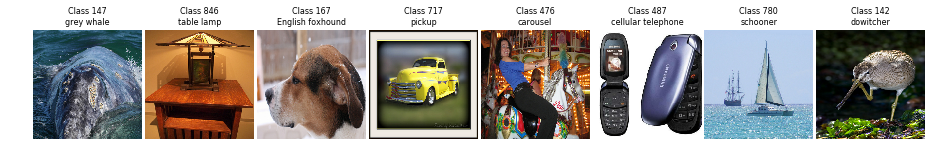

In [25]:
viz_utils.display_dataset(partial(dataset_utils.get_ilsvrc_dataset,
                                  batch_size=8,
                                  image_dir=os.path.expanduser('~/Datasets/ILSVRC2012/'),
                                  image_size=224,
                                  val_tfrecords='Data/ilsvrc2012/tf_ilsvrc2012_25-30_val'),
                          mode='val', verbose=True)

4. We load the pretrained ImageNet InceptionV2 from tensornets and save it as a Tensorflow checkpoint which can easily be restored in our implementation. The model is saved in `Data/pretrained_models/pretrained_ilsvrc2012`

Predict on image /nfs/scistore12/chlgrp/aroyer/Datasets/ILSVRC2012/val/ILSVRC2012_val_00000003.JPEG
Predicted class: 230 (logit score =  0.72119)


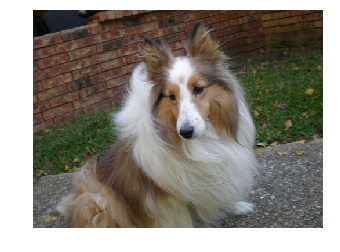

In [7]:
import sys
sys.path.append('/nfs/scistore12/chlgrp/aroyer/Libs/tensornets/')
import tensornets as nets

# Test on one image
img_path = '/nfs/scistore12/chlgrp/aroyer/Datasets/ILSVRC2012/val/ILSVRC2012_val_00000003.JPEG'
with tf.Graph().as_default():
    img1 = mpimg.imread(img_path)
    img = tf.expand_dims(img1, axis=0)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_images(img, (224, 224))
    with tf.variable_scope('imagenet_net'):
        logits = nets.Inception2((img - 0.5) * 2, scope='InceptionV2', reuse=False, is_training=False)
        op = logits.pretrained()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(op)        
        logits_ = sess.run(logits)
        saver.save(sess, 'Data/pretrained_models/pretrained_ilsvrc2012/model')
        print('Predict on image', img_path)
        print('Predicted class: %d (logit score =  %.5f)' % (np.argmax(logits_, axis=-1), np.amax(logits_)))
        plt.imshow(img1)
        plt.axis('off')
    plt.show()

4. Evaluate the pretrained model

In [28]:
%%time
save_log_dir = 'Data/pretrained_models/pretrained_ilsvrc2012/'

base_config = {}
base_config['batch_size'] = 32
base_config['image_size'] = 256
base_config['crop_size'] = 224
base_config['image_dir'] = os.path.expanduser('~/Datasets/ILSVRC2012/')
base_config['val_tfrecords'] = 'Data/ilsvrc2012/tf_ilsvrc2012_25-30_val'
base_config['test_tfrecords'] = 'Data/ilsvrc2012/tf_ilsvrc2012_30-50_test'

classifier = classifiers.ILSVRCClassifier(dataset_utils.get_ilsvrc_dataset, config=base_config)
top1_accuracy_, top5_accuracy_ = classifier.test(
    save_log_dir, mode='val', verbose=True)
print('val accuracy = %.5f, top5 = %.5f' % (top1_accuracy_, top5_accuracy_))

classifier.reset_graph()
top1_accuracy_, top5_accuracy_ = classifier.test(
    save_log_dir, mode='test', verbose=True)
print('test accuracy = %.5f, top5 = %.5f' % (top1_accuracy_, top5_accuracy_))

   Loading imagenet_net checkpoint from Data/pretrained_models/pretrained_ilsvrc2012/model
   (eval) step 157          
val accuracy = 0.74420, top5 = 0.92120
   Loading imagenet_net checkpoint from Data/pretrained_models/pretrained_ilsvrc2012/model
   (eval) step 625          
test accuracy = 0.75080, top5 = 0.92295
CPU times: user 5min 50s, sys: 47.1 s, total: 6min 37s
Wall time: 2min 37s


# CIFAR-10

1. Write TFRecords. Split the original training dataset into:
 * 2 batches used to train the pretrained model
 * 2 batches used to generate the synthetic shifted domains (noise, blur etc)
 * 1 batch for validation
 * 1 batch (original) for test
 
We also filter out the class `deer` as it is not present in the target domain, QuickDraw

In [29]:
source_dir = os.path.expanduser('~/Datasets/cifar-10-batches-py/')
tfrecords_path = 'Data/cifar/tf_cifar_%s'

In [130]:
%%time
import pickle
def unpickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f, encoding='bytes')

    
# Load batches
pretrain_batches = [os.path.join(source_dir, 'data_batch_%d' % (i + 1)) for i in range(2)]
train_batches = [os.path.join(source_dir, 'data_batch_%d' % (i + 1)) for i in range(2, 4)]
val_batches = [os.path.join(source_dir, 'data_batch_5')]
test_batches = [os.path.join(source_dir, 'test_batch')]
label_names = unpickle(os.path.join(source_dir, 'batches.meta'))[b'label_names']

# Write TFRecords
for name, data in [('pretrain', pretrain_batches), ('train', train_batches),
                   ('val', val_batches), ('test', test_batches)]:
    writer_path = tfrecords_path % name
    writer = tf.python_io.TFRecordWriter(writer_path)
    print('\nLoad', name)
    for i, item in enumerate(data):
        print('\rBatch %d/%d' % (i + 1, len(data)), end='')
        d = unpickle(item)
        for img, label in zip(d[b'data'], d[b'labels']):    
            class_name = label_names[label]
            if label == 4:
                continue
            elif label > 4:
                label -= 1
            img = np.transpose(np.reshape(img, (3, 32, 32)), (1, 2, 0))
            example = tf.train.Example(features=tf.train.Features(
                    feature={'image': bytes_feature([img.astype(np.uint8).tostring(order='C')]),
                             'class': int64_feature([label]),
                             'class_name': bytes_feature([base64.b64encode(class_name)])}))
            writer.write(example.SerializeToString())
    writer.close()
    print('\nWrote %s in file %s' % (name, writer_path))
print()


Load pretrain
Batch 2/2
Wrote pretrain in file Data/cifar/tf_cifar_pretrain

Load train
Batch 2/2
Wrote train in file Data/cifar/tf_cifar_train

Load val
Batch 1/1
Wrote val in file Data/cifar/tf_cifar_val

Load test
Batch 1/1
Wrote test in file Data/cifar/tf_cifar_test

CPU times: user 5.62 s, sys: 227 ms, total: 5.85 s
Wall time: 6.06 s


2. Vizualise

   class: (?,)
   class_name: (?,)
   image: (?, 32, 32, 3)
   9003 samples in dataset
   0 (1014), 1 (1014), 2 (952), 3 (1016), 4 (1025), 5 (980), 6 (977), 7 (1003), 8 (1022)


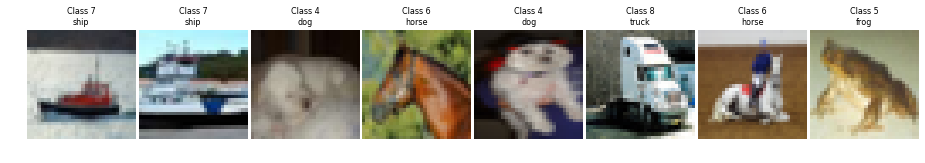

In [30]:
viz_utils.display_dataset(partial(dataset_utils.get_cifar_dataset,
                                  batch_size=8,
                                  shuffle_test=True,
                                  shuffle_buffer=1000,
                                  val_tfrecords=tfrecords_path % 'val'),
                          mode='val', verbose=True)

3. Pretrain a  model on the 2 kept-out batches

In [32]:
## Initialize the configuration
output_dir = 'Data/pretrained_models/'
save_log_dir = os.path.join(output_dir, 'pretrained_cifar/')
tfrecords_path = 'Data/cifar/tf_cifar_%s'

config = {}
config['batch_size'] = 50
config['train_tfrecords'] = tfrecords_path % 'pretrain'
for key in ['val', 'test']:
    config['%s_tfrecords' % key] = tfrecords_path % key

In [134]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
pretrain_config = config.copy()
pretrain_config['num_epochs'] = 50
pretrain_config['learning_rate'] = 1e-3
pretrain_config['shuffle_buffer'] = 10000
pretrain_config['num_train_devices'] = 1
pretrain_config['save_checkpoint_secs'] = 3600
pretrain_config['eval_epsilon'] = 0.01
pretrain_config['eval_step'] = 1000
    
classifier = classifiers.CIFARClassifier(dataset_utils.get_cifar_dataset, config=pretrain_config)
_ = classifier.train_and_eval(save_checkpoint_secs=pretrain_config['save_checkpoint_secs'], 
                              save_log_dir=save_log_dir,
                              display_step=50, 
                              verbose=True)


Graph:
   Using 1 train devices
   in: (?, 32, 32, 3)
   conv1: (?, 32, 32, 32)
   conv2: (?, 16, 16, 64)
   conv3: (?, 8, 8, 128)
   conv4: (?, 4, 4, 256)
   conv5: (?, 2, 2, 512)
   fc: (?, 1024)
   out: (?, 9)
   Train with Adam Optimizer and lr = 0.0010:
      > cifar_net/layer_1/conv_1/weights:0
      > cifar_net/layer_1/conv_1/biases:0
      > cifar_net/layer_2/conv_2/weights:0
      > cifar_net/layer_2/conv_2/biases:0
      > cifar_net/layer_3/conv_3/weights:0
      > cifar_net/layer_3/conv_3/biases:0
      > cifar_net/layer_4/conv_4/weights:0
      > cifar_net/layer_4/conv_4/biases:0
      > cifar_net/layer_5/conv_5/weights:0
      > cifar_net/layer_5/conv_5/biases:0
      > cifar_net/layer_6/fc_1/weights:0
      > cifar_net/layer_6/fc_1/biases:0
      > cifar_net/layer_7/fc_2/weights:0
      > cifar_net/layer_7/fc_2/biases:0
    0 update operations found

Train:
   Saving checkpoint in Data/cifar/pretrained/pretrained_cifar/
   (eval) step 181          
   (train) step 000179

In [34]:
%%time
# Evaluate
classifier = classifiers.CIFARClassifier(dataset_utils.get_cifar_dataset, config=config)
_ = classifier.test(save_log_dir, mode='val', verbose=False)

classifier.reset_graph()
_ = classifier.test(save_log_dir, mode='test', verbose=False)
print(classifier.info)

Config
------
*batch_size* = 50
*test_tfrecords* = Data/cifar/tf_cifar_test
*train_tfrecords* = Data/cifar/tf_cifar_pretrain
*val_tfrecords* = Data/cifar/tf_cifar_val
*dataset_fn* = functools.partial(<function _get_basic_dataset at 0x7f8080eb6d08>, parsing_fn=<function cifar_parsing_fn at 0x7f8080eb66a8>)
*preprocess_fn* = functools.partial(<function pix2pix_preprocess at 0x7f815a124b70>, num_outputs=3)
*transition_fn* = functools.partial(<function cifar_transition at 0x7f815a124a60>, num_channels=3)
*feed_forward_fn* = <function cifar_net at 0x7f8080eb9268>

val evaluation log
--------
   Loading cifar_net checkpoint from Data/pretrained_models/pretrained_cifar/model.ckpt-17991
   Restoring variables
      > cifar_net/layer_1/conv_1/weights:0
      > cifar_net/layer_1/conv_1/biases:0
      > cifar_net/layer_2/conv_2/weights:0
      > cifar_net/layer_2/conv_2/biases:0
      > cifar_net/layer_3/conv_3/weights:0
      > cifar_net/layer_3/conv_3/biases:0
      > cifar_net/layer_4/conv_4/w

5. Generate domain shift with noise


Load train
Batch 2/2
Wrote train in file Data/cifar/tf_noisy_cifar_train

Load val
Batch 1/1
Wrote val in file Data/cifar/tf_noisy_cifar_val

Load test
Batch 1/1
Wrote test in file Data/cifar/tf_noisy_cifar_test



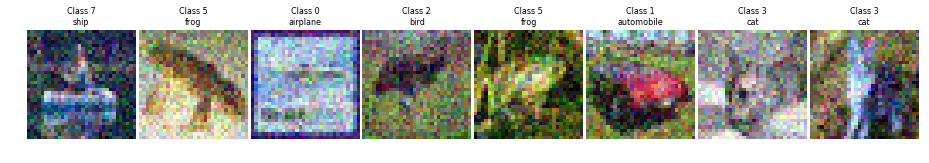

CPU times: user 14.7 s, sys: 588 ms, total: 15.3 s
Wall time: 15.1 s


In [162]:
%%time
# Load batches
std = 30
seed = 42
tfrecords_path = 'Data/cifar/tf_noisy_cifar_%s'
train_batches = [os.path.join(source_dir, 'data_batch_%d' % (i + 1)) for i in range(2, 4)]
val_batches = [os.path.join(source_dir, 'data_batch_5')]
test_batches = [os.path.join(source_dir, 'test_batch')]
label_names = unpickle(os.path.join(source_dir, 'batches.meta'))[b'label_names']

# Write TFRecords
state = np.random.get_state()
np.random.seed(seed)
try:        
    for name, data in [('train', train_batches), ('val', val_batches), ('test', test_batches)]:
        writer_path = tfrecords_path % name
        writer = tf.python_io.TFRecordWriter(writer_path)
        print('\nLoad', name)
        for i, item in enumerate(data):
            print('\rBatch %d/%d' % (i + 1, len(data)), end='')
            d = unpickle(item)
            for img, label in zip(d[b'data'], d[b'labels']):    
                class_name = label_names[label]
                if label == 4:
                    continue
                elif label > 4:
                    label -= 1
                img = np.transpose(np.reshape(img, (3, 32, 32)), (1, 2, 0))
                noise = np.random.normal(scale=std, size=(32, 32, 3))
                img = np.clip(img + noise, 0., 255.)
                example = tf.train.Example(features=tf.train.Features(
                        feature={'image': bytes_feature([img.astype(np.uint8).tostring(order='C')]),
                                 'class': int64_feature([label]),
                                 'class_name': bytes_feature([base64.b64encode(class_name)])}))
                writer.write(example.SerializeToString())
        writer.close()
        print('\nWrote %s in file %s' % (name, writer_path))
    print()
finally:
    np.random.set_state(state)
    

viz_utils.display_dataset(partial(dataset_utils.get_cifar_dataset,
                                  batch_size=8,
                                  shuffle_test=True,
                                  shuffle_buffer=1000,
                                  val_tfrecords=tfrecords_path % 'val'),
                          mode='val', verbose=False)

# QuickDraw

In [35]:
quickdraw = '/nfs/scistore12/chlgrp/aroyer/Datasets/QuickDraw/'
tfrecords_path = 'Data/cifar/tf_quickdraw_%s'

1. Create TFRecords with 10000 images per class and restricted to the same class as CIFAR (-`deer`)

In [168]:
image_limit = 10000   # number of images to load per class
classes = {
    'full%2Fnumpy_bitmap%2Ftruck.npy': (b'truck', 8), 
    'full%2Fnumpy_bitmap%2Fcruise ship.npy': (b'ship', 7),
    'full%2Fnumpy_bitmap%2Fhorse.npy': (b'horse', 6), 
    'full%2Fnumpy_bitmap%2Ffrog.npy': (b'frog', 5), 
    'full%2Fnumpy_bitmap%2Fcat.npy': (b'cat', 3),
    'full%2Fnumpy_bitmap%2Fairplane.npy': (b'airplane', 0), 
    'full%2Fnumpy_bitmap%2Fbird.npy': (b'bird', 2), 
    'full%2Fnumpy_bitmap%2Fcar.npy': (b'automobile', 1),
    'full%2Fnumpy_bitmap%2Fdog.npy': (b'dog', 4)
}

In [169]:
%%time
num_images = 0
writer_path = tfrecords_path % 'base'
writer = tf.python_io.TFRecordWriter(writer_path)
for npy_file in os.listdir(quickdraw):
    class_name, label = classes[npy_file]
    data = np.load(os.path.join(quickdraw, npy_file))
    for i, img in enumerate(data[:image_limit]):
        img = 255 - np.reshape(img, (28, 28, 1))
        example = tf.train.Example(features=tf.train.Features(
            feature={'image': bytes_feature([img.astype(np.uint8).tostring(order='C')]),
                     'class': int64_feature([label]),
                     'class_name': bytes_feature([base64.b64encode(class_name)])}))
        writer.write(example.SerializeToString())
        num_images += 1
writer.close()
print('Wrote %d images' % num_images)

Wrote 90000 images
CPU times: user 9.88 s, sys: 738 ms, total: 10.6 s
Wall time: 10.8 s


In [170]:
%%time
preprocess_utils.split_tf_records('Data/cifar/tf_quickdraw_base', 
                                  'Data/cifar/tf_quickdraw_pretrain', 
                                  take=35000, shuffle=True, seed=42, num_elements=90000)
preprocess_utils.split_tf_records('Data/cifar/tf_quickdraw_base', 
                                  'Data/cifar/tf_quickdraw_train', 
                                  skip=35000, take=30000, shuffle=True, seed=42, num_elements=90000)
preprocess_utils.split_tf_records('Data/cifar/tf_quickdraw_base', 
                                  'Data/cifar/tf_quickdraw_val', 
                                  skip=70000, take=5000, shuffle=True, seed=42, num_elements=90000)
preprocess_utils.split_tf_records('Data/cifar/tf_quickdraw_base', 
                                  'Data/cifar/tf_quickdraw_test', 
                                  skip=75000, shuffle=True, seed=42, num_elements=90000)

CPU times: user 2.56 s, sys: 68.5 ms, total: 2.62 s
Wall time: 2.67 s


2.Vizualise

   class: (?,)
   class_name: (?,)
   image: (?, 28, 28, 1)
   5000 samples in dataset
   0 (551), 1 (566), 2 (534), 3 (539), 4 (547), 5 (542), 6 (588), 7 (567), 8 (566)


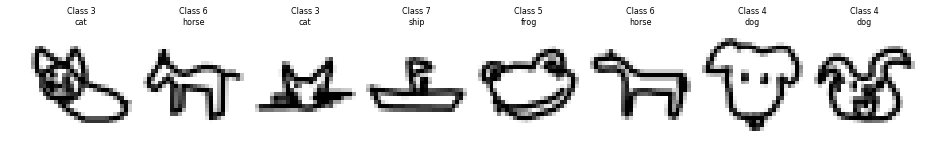

In [41]:
viz_utils.display_dataset(partial(dataset_utils.get_quickdraw_dataset,
                                  batch_size=8,
                                  shuffle_test=True,
                                  shuffle_buffer=5000,
                                  val_tfrecords=tfrecords_path % 'val'),
                          mode='val', verbose=True)

3. Pretrain model

In [42]:
# Initialize configuration
output_dir = 'Data/pretrained_models/'
save_log_dir = os.path.join(output_dir, 'pretrained_quickdraw/')
tfrecords_path = 'Data/cifar/tf_quickdraw_%s'

config = {}
config['batch_size'] = 50
config['image_size'] = 32
config['train_tfrecords'] = tfrecords_path % 'pretrain'
for key in ['val', 'test']:
    config['%s_tfrecords' % key] = tfrecords_path % key

In [209]:
# Train
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
pretrain_config = config.copy()
pretrain_config['num_epochs'] = 50
pretrain_config['learning_rate'] = 1e-3
pretrain_config['shuffle_buffer'] = 10000
pretrain_config['num_train_devices'] = 1
pretrain_config['save_checkpoint_secs'] = 3600
pretrain_config['eval_epsilon'] = 0.025
pretrain_config['eval_step'] = 1000
    
classifier = classifiers.QuickDrawClassifier(dataset_utils.get_quickdraw_dataset, config=pretrain_config)
_ = classifier.train_and_eval(save_checkpoint_secs=pretrain_config['save_checkpoint_secs'], 
                              save_log_dir=save_log_dir,
                              display_step=50,
                              verbose=True)


Graph:
   Using 1 train devices
   in: (?, 32, 32, 1)
   conv1: (?, 32, 32, 32)
   conv2: (?, 16, 16, 64)
   conv3: (?, 8, 8, 128)
   conv4: (?, 4, 4, 256)
   conv5: (?, 2, 2, 512)
   fc: (?, 1024)
   out: (?, 9)
   Train with Adam Optimizer and lr = 0.0010:
      > cifar_net/layer_1/conv_1/weights:0
      > cifar_net/layer_1/conv_1/biases:0
      > cifar_net/layer_2/conv_2/weights:0
      > cifar_net/layer_2/conv_2/biases:0
      > cifar_net/layer_3/conv_3/weights:0
      > cifar_net/layer_3/conv_3/biases:0
      > cifar_net/layer_4/conv_4/weights:0
      > cifar_net/layer_4/conv_4/biases:0
      > cifar_net/layer_5/conv_5/weights:0
      > cifar_net/layer_5/conv_5/biases:0
      > cifar_net/layer_6/fc_1/weights:0
      > cifar_net/layer_6/fc_1/biases:0
      > cifar_net/layer_7/fc_2/weights:0
      > cifar_net/layer_7/fc_2/biases:0
    0 update operations found

Train:
   Saving checkpoint in Data/cifar/pretrained/pretrained_quickdraw/
   (eval) step 100          
   (train) step 00

4. Evaluate the pretrained model

In [43]:
%%time
# Evaluate
classifier = classifiers.QuickDrawClassifier(dataset_utils.get_quickdraw_dataset, config=config)
_ = classifier.test(save_log_dir, mode='val', verbose=False)

classifier.reset_graph()
_ = classifier.test(save_log_dir, mode='test', verbose=False)
print(classifier.info)

Config
------
*batch_size* = 50
*image_size* = 32
*test_tfrecords* = Data/cifar/tf_quickdraw_test
*train_tfrecords* = Data/cifar/tf_quickdraw_pretrain
*val_tfrecords* = Data/cifar/tf_quickdraw_val
*dataset_fn* = functools.partial(<function _get_basic_dataset at 0x7f8080eb6d08>, parsing_fn=functools.partial(<function cifar_parsing_fn at 0x7f8080eb66a8>, shape=(28, 28, 1)))
*preprocess_fn* = functools.partial(<function pix2pix_preprocess at 0x7f815a124b70>, num_outputs=1)
*transition_fn* = functools.partial(<function cifar_transition at 0x7f815a124a60>, num_channels=1)
*feed_forward_fn* = <function cifar_net at 0x7f8080eb9268>

val evaluation log
--------
   Loading cifar_net checkpoint from Data/pretrained_models/pretrained_quickdraw/model.ckpt-3000
   Restoring variables
      > cifar_net/layer_1/conv_1/weights:0
      > cifar_net/layer_1/conv_1/biases:0
      > cifar_net/layer_2/conv_2/weights:0
      > cifar_net/layer_2/conv_2/biases:0
      > cifar_net/layer_3/conv_3/weights:0
     

5. Generate noisy counterpart

Wrote 90000 images


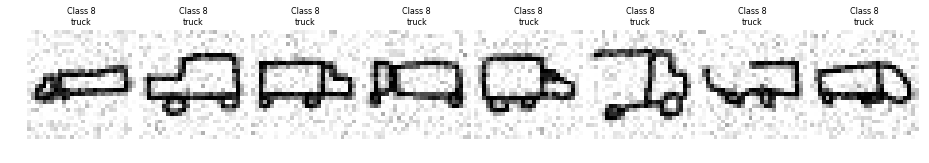

CPU times: user 21.3 s, sys: 1.32 s, total: 22.6 s
Wall time: 22.5 s


In [173]:
%%time
tfrecords_path = 'Data/cifar/tf_noisy_quickdraw_%s'
state = np.random.get_state()
np.random.seed(seed)
try:        
    num_images = 0
    writer_path = tfrecords_path % 'base'
    writer = tf.python_io.TFRecordWriter(writer_path)
    for npy_file in os.listdir(quickdraw):
        class_name, label = classes[npy_file]
        data = np.load(os.path.join(quickdraw, npy_file))
        for i, img in enumerate(data[:image_limit]):
            img = 255 - np.reshape(img, (28, 28, 1))
            noise = np.random.normal(scale=std, size=(28, 28, 1))
            img = np.clip(img + noise, 0., 255.)
            example = tf.train.Example(features=tf.train.Features(
                feature={'image': bytes_feature([img.astype(np.uint8).tostring(order='C')]),
                         'class': int64_feature([label]),
                         'class_name': bytes_feature([base64.b64encode(class_name)])}))
            writer.write(example.SerializeToString())
            num_images += 1
    writer.close()
    print('Wrote %d images' % num_images)
finally:
    np.random.set_state(state)
    
preprocess_utils.split_tf_records('Data/cifar/tf_noisy_quickdraw_base', 
                                  'Data/cifar/tf_noisy_quickdraw_pretrain', 
                                  take=35000, shuffle=True, seed=42, num_elements=90000)
preprocess_utils.split_tf_records('Data/cifar/tf_noisy_quickdraw_base', 
                                  'Data/cifar/tf_noisy_quickdraw_train', 
                                  skip=35000, take=30000, shuffle=True, seed=42, num_elements=90000)
preprocess_utils.split_tf_records('Data/cifar/tf_noisy_quickdraw_base', 
                                  'Data/cifar/tf_noisy_quickdraw_val', 
                                  skip=70000, take=5000, shuffle=True, seed=42, num_elements=90000)
preprocess_utils.split_tf_records('Data/cifar/tf_noisy_quickdraw_base', 
                                  'Data/cifar/tf_noisy_quickdraw_test', 
                                  skip=75000, shuffle=True, seed=42, num_elements=90000)
    
viz_utils.display_dataset(partial(dataset_utils.get_quickdraw_dataset,
                                  batch_size=8,
                                  val_tfrecords=tfrecords_path % 'val'),
                          mode='val', verbose=False)